# Hackathon - Team Sample (small sample train data)

- [Reading_In_and_Cleaning](#Reading-In-and-Cleaning)
- [EDA](#EDA)
- [Polynomial Features](#Polynomial-Features)
- [Modeling](#Modeling)
- [Baseline Model](#Baseline-Model)
- [Random Forest](#Random-Forest-Results)
- [KNN](#KNN-Results)
- [Logistic Regression](#Logistic-Regression-Results)
- [Exploring False Predictions](#Exploring-False-Predictions)

## Imports

In [47]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Reading In and Cleaning

In [48]:
df = pd.read_csv('./data/cheap_train_sample.csv')
df2 = pd.read_csv('./data/cheap_train_sample.csv')
test = pd.read_csv('./data/test_data.csv')

In [49]:
# Cleaning

columns_to_clean = ['workclass', 'marital-status', 'relationship', 'sex', 'native-country']

def clean(df, columns):
    for col in columns:
        df[col] = df[col].str.strip().str.lower()
    
clean(df, columns_to_clean)
clean(df2, columns_to_clean)
clean(test, columns_to_clean)

# binary target
df['wage'] = df['wage'].map(lambda x: 1 if x == " >50K" else 0)
df2['wage'] = df2['wage'].map(lambda x: 1 if x == " >50K" else 0)


# replacing ?

df.replace(to_replace=' ?', value='Unknown', inplace=True)
df2.replace(to_replace=' ?', value='Unknown', inplace=True)
test.replace(to_replace=' ?', value='Unknown', inplace=True)

# creating dummies
df = pd.get_dummies(df, columns=['sex', 'relationship', 
                                 'marital-status', 'native-country', 
                                 'workclass'], drop_first=True)
test = pd.get_dummies(test, columns=['sex', 'relationship', 
                                 'marital-status', 'native-country', 
                                 'workclass'], drop_first=True)



## EDA

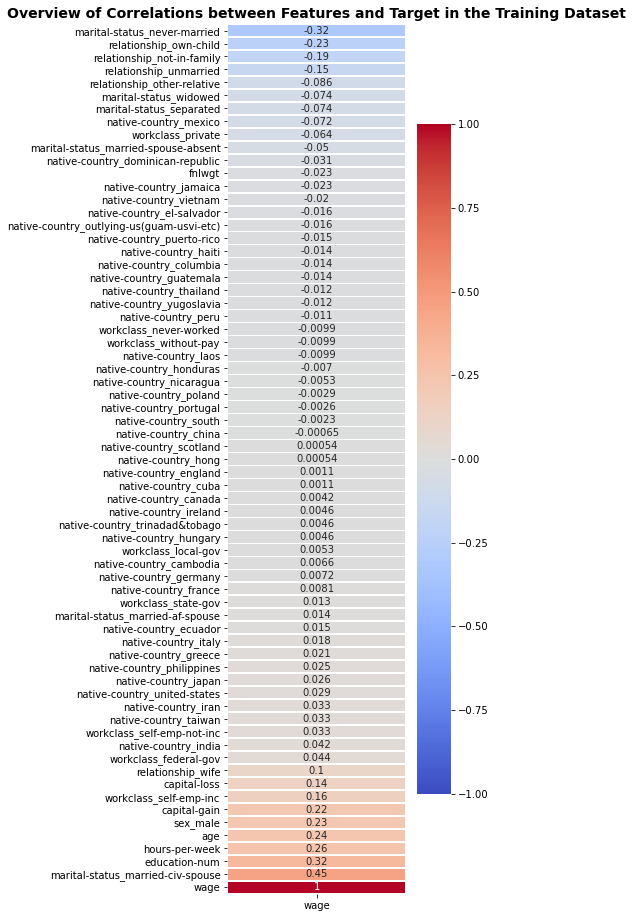

In [50]:
plt.figure(figsize=(4, 16))
sns.heatmap(data = df.corr()[['wage']].sort_values('wage'), annot = True, linewidths=.5, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.title('Overview of Correlations between Features and Target in the Training Dataset', fontweight = 'bold', fontsize = 14);

In [51]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,wage,sex_male,relationship_not-in-family,relationship_other-relative,...,native-country_vietnam,native-country_yugoslavia,workclass_federal-gov,workclass_local-gov,workclass_never-worked,workclass_private,workclass_self-emp-inc,workclass_self-emp-not-inc,workclass_state-gov,workclass_without-pay
count,6513.000000,6.513000e+03,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,...,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000
mean,38.529556,1.926640e+05,10.068478,1059.200829,92.108092,40.400891,0.240749,0.664210,0.255643,0.029787,...,0.001228,0.000461,0.029019,0.064640,0.000307,0.697835,0.034546,0.077384,0.040227,0.000307
std,13.684351,1.060173e+05,2.589238,7392.040587,413.710886,12.354685,0.427571,0.472302,0.436255,0.170011,...,0.035028,0.021459,0.167872,0.245908,0.017522,0.459232,0.182642,0.267220,0.196507,0.017522
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,1.202380e+05,9.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,1.815760e+05,10.000000,0.000000,0.000000,40.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,48.000000,2.417530e+05,13.000000,0.000000,0.000000,45.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,90.000000,1.366120e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [52]:
vis = pd.read_csv('./data/cheap_train_sample.csv')

vis['wage'] = vis['wage'].map(lambda x: 1 if x == " >50K" else 0)

high_wage = vis[vis['wage'] == 1]
low_wage = vis[vis['wage'] == 0]

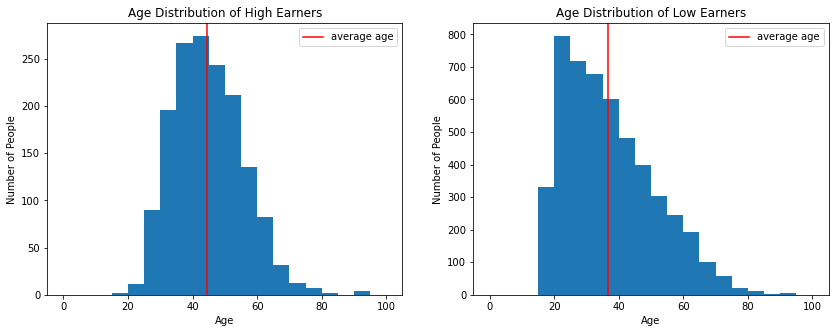

In [53]:
fig, ax = plt.subplots(1, 2, figsize = (14, 5))

ax[0].hist(high_wage['age'], bins = 20, range = (0, 100))
ax[0].axvline(x = high_wage['age'].mean(), c = 'r', label = 'average age')
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Number of People')
ax[0].set_title('Age Distribution of High Earners')
ax[0].legend()

ax[1].hist(low_wage['age'], bins = 20, range = (0, 100))
ax[1].axvline(x = low_wage['age'].mean(), c = 'r', label = 'average age')
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Number of People')
ax[1].set_title('Age Distribution of Low Earners')
ax[1].legend();

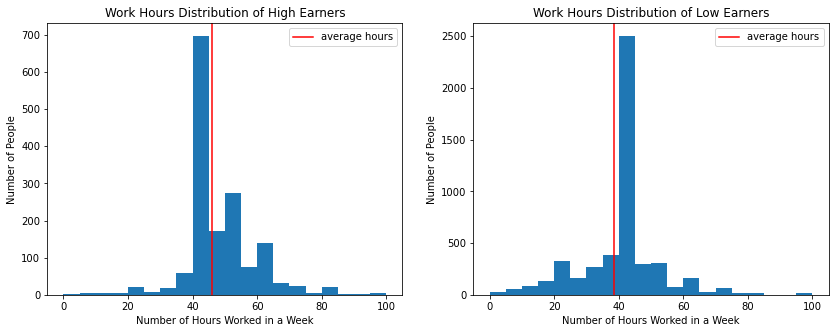

In [54]:
fig, ax = plt.subplots(1, 2, figsize = (14, 5))

ax[0].hist(high_wage['hours-per-week'], bins = 20, range = (0, 100))
ax[0].axvline(x = high_wage['hours-per-week'].mean(), c = 'r', label = 'average hours')
ax[0].set_xlabel('Number of Hours Worked in a Week')
ax[0].set_ylabel('Number of People')
ax[0].set_title('Work Hours Distribution of High Earners')
ax[0].legend()

ax[1].hist(low_wage['hours-per-week'], bins = 20, range = (0, 100))
ax[1].axvline(x = low_wage['hours-per-week'].mean(), c = 'r', label = 'average hours')
ax[1].set_xlabel('Number of Hours Worked in a Week')
ax[1].set_ylabel('Number of People')
ax[1].set_title('Work Hours Distribution of Low Earners')
ax[1].legend();

## Polynomial Features

In [55]:
# attempting feature engineering 
FEATURES = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
X = df[FEATURES]
y = df['wage'].values

# instantiate polynomialfeatures
poly = PolynomialFeatures(include_bias = False)

# create X_poly
poly.fit(X)
X_poly = poly.transform(X)

# train test split
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X_poly, y, random_state = 24)

# ss
ss = StandardScaler()
X_poly_train_sc = ss.fit_transform(X_poly_train)
X_poly_test_sc = ss.transform(X_poly_test)

# model.fit(X_poly, y)
lr = LogisticRegression(n_jobs = -1)
lr.fit(X_poly_train_sc, y_poly_train)

# get a prediciton
predictions = lr.predict(X_poly_test_sc)

# score
lr.score(X_poly_train_sc, y_poly_train), lr.score(X_poly_test_sc, y_poly_test)

# get feature names
sorted(list(zip(np.exp(lr.coef_[0]), poly.get_feature_names(FEATURES))))

[(0.07276000248306867, 'age^2'),
 (0.3597254017208442, 'hours-per-week^2'),
 (0.5949275932717866, 'capital-gain^2'),
 (0.7477325221529569, 'age hours-per-week'),
 (0.7688635638822467, 'capital-gain hours-per-week'),
 (0.8219280734693449, 'age fnlwgt'),
 (0.8286350436119015, 'education-num hours-per-week'),
 (0.8369011011150872, 'fnlwgt^2'),
 (0.8432705825467544, 'fnlwgt education-num'),
 (0.8631662386462599, 'capital-loss^2'),
 (0.9080619795818172, 'capital-loss hours-per-week'),
 (0.9254956677938059, 'age capital-loss'),
 (1.0, 'capital-gain capital-loss'),
 (1.1083525701534138, 'fnlwgt capital-loss'),
 (1.1179977426810224, 'age capital-gain'),
 (1.134223922762992, 'education-num capital-loss'),
 (1.2681491165115075, 'age education-num'),
 (1.2744288792629501, 'fnlwgt hours-per-week'),
 (1.282320860191826, 'fnlwgt capital-gain'),
 (1.3129809111855073, 'fnlwgt'),
 (1.3291516218670167, 'education-num^2'),
 (1.4148710981587618, 'capital-loss'),
 (1.5584066352846953, 'education-num'),
 (2

In [56]:
# did not help our model
df['edu-num_times_cap-gain'] = df['education-num'] * df['capital-gain']

## Modeling

In [57]:
# setting up X and y

X = df.drop(columns=['education', 'occupation', 'wage', 'edu-num_times_cap-gain'])
y = df['wage']


# need to scale data for knn and logisticregression
# use pipeline since we don't need standard scaled data for random forest
knn_pipe = Pipeline([
    ('ss', StandardScaler()), 
    ('knn', KNeighborsClassifier())
])

lr_pipe = Pipeline([
    ('ss', StandardScaler()), 
    ('lr', LogisticRegression())
])


# instantiating my models
# found these numbers for RF through gridsearch

#params found through gridsearch
rf = RandomForestClassifier(bootstrap=False, max_depth=60, 
                            max_features='auto', min_samples_leaf=2, 
                            n_estimators=200)
knn = KNeighborsClassifier()
lr = LogisticRegression()

# creating variables for cross_validate scores
rf_scores = cross_validate(rf, X, y, cv = KFold(n_splits=5, 
                                                      shuffle=True, 
                                                      random_state=73),
                                                      n_jobs=-1,
                                                      return_train_score=True, 
                                                      return_estimator=True)

knn_scores = cross_validate(knn_pipe, X, y, cv = KFold(n_splits=5, 
                                                      shuffle=True, 
                                                      random_state=73), 
                                                      n_jobs=-1,
                                                      return_train_score=True, 
                                                      return_estimator=True)

lr_scores = cross_validate(lr_pipe, X, y, cv = KFold(n_splits=5, 
                                                      shuffle=True, 
                                                      random_state=73),
                                                      n_jobs=-1,
                                                      return_train_score=True, 
                                                      return_estimator=True)

# saving scores into separate dataframes
rf_results = pd.DataFrame(rf_scores)
knn_results = pd.DataFrame(knn_scores)
lr_results = pd.DataFrame(lr_scores)

### Baseline Model

In [58]:
# baseline 76%
df['wage'].value_counts(normalize=True)

0    0.759251
1    0.240749
Name: wage, dtype: float64

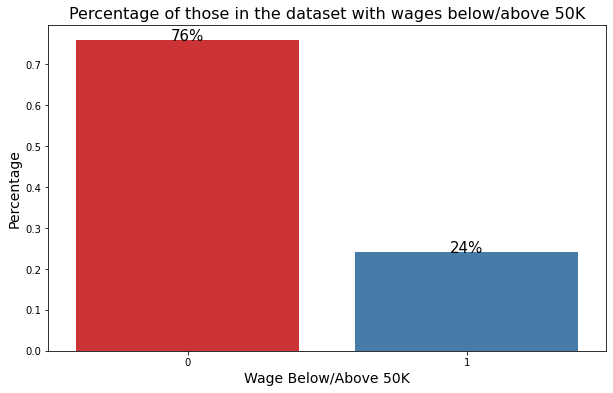

In [59]:
# source: https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/

# bar graph to represent imbalance of data
#Ploting barplot for target 
plt.figure(figsize=(10,6))
g = sns.barplot(df['wage'], df['wage'], palette='Set1', estimator=lambda x: len(x) / len(df) )

#Anotating the graph
for p in g.patches:
        width, height = p.get_width(), p.get_height()
        x, y_ = p.get_xy() 
        g.text(x+width/2, 
               y_+height, 
               '{:.0%}'.format(height), 
               horizontalalignment='center',fontsize=15)

#Setting the labels
plt.xlabel('Wage Below/Above 50K', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.title('Percentage of those in the dataset with wages below/above 50K', fontsize=16);

### Random Forest Results

In [60]:
rf_results

,fit_time,score_time,estimator,test_score,train_score
0,1.605400,0.075627,"(DecisionTreeClassifier(max_depth=60, max_feat...",0.844973,0.928791
1,1.598313,0.069674,"(DecisionTreeClassifier(max_depth=60, max_feat...",0.838066,0.931094
2,1.594475,0.076301,"(DecisionTreeClassifier(max_depth=60, max_feat...",0.840368,0.932438
3,1.576928,0.068157,"(DecisionTreeClassifier(max_depth=60, max_feat...",0.860983,0.928996
4,1.570572,0.065387,"(DecisionTreeClassifier(max_depth=60, max_feat...",0.857143,0.926118


In [61]:
print(round(rf_results['test_score'].mean(), 3), ',', round(rf_results['train_score'].mean(), 3))

print(f'{round(rf_results.test_score.mean(), 3)} ± {round(2 * rf_results.test_score.std(), 3)}')

0.848 , 0.929
0.848 ± 0.02


### Confusion Matrix

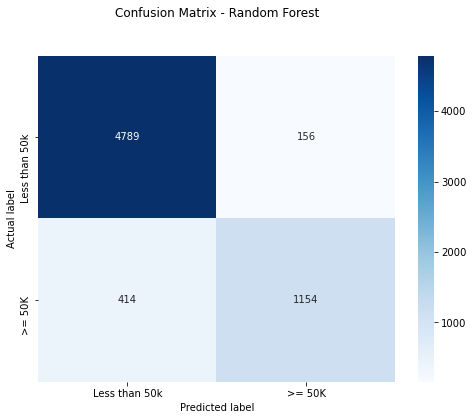

In [62]:
rf_preds = rf_scores.get('estimator')[1].predict(X)

metrics.confusion_matrix(y, rf_preds)

confusion_matrix_df = pd.DataFrame(metrics.confusion_matrix(y, rf_preds))
confusion_matrix_df.rename(columns = {0:'Less than 50k', 1: '>= 50K'}, inplace = True)
confusion_matrix_df.rename(index = {0:'Less than 50k', 1: '>= 50K'}, inplace = True)
confusion_matrix_df


plt.figure(figsize=(8, 6))

# create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix_df), annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix - Random Forest', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

### KNN Results

In [63]:
knn_results

,fit_time,score_time,estimator,test_score,train_score
0,0.051805,0.411593,"(StandardScaler(), KNeighborsClassifier())",0.818880,0.873129
1,0.019426,0.645150,"(StandardScaler(), KNeighborsClassifier())",0.805065,0.870633
2,0.020281,0.668212,"(StandardScaler(), KNeighborsClassifier())",0.810437,0.871401
3,0.020496,0.660728,"(StandardScaler(), KNeighborsClassifier())",0.817204,0.866628
4,0.021042,0.667962,"(StandardScaler(), KNeighborsClassifier())",0.820276,0.865285


In [64]:
print(round(knn_results['test_score'].mean(), 3), ',', round(knn_results['train_score'].mean(), 3))

print(f'{round(knn_results.test_score.mean(), 3)} ± {round(2 * knn_results.test_score.std(), 3)}')

0.814 , 0.869
0.814 ± 0.013


### Logistic Regression Results

In [65]:
lr_results

,fit_time,score_time,estimator,test_score,train_score
0,0.061766,0.003394,"(StandardScaler(), LogisticRegression())",0.838066,0.849136
1,0.092943,0.004048,"(StandardScaler(), LogisticRegression())",0.836531,0.849136
2,0.088938,0.004045,"(StandardScaler(), LogisticRegression())",0.830391,0.850096
3,0.072894,0.004987,"(StandardScaler(), LogisticRegression())",0.850230,0.845327
4,0.058737,0.002571,"(StandardScaler(), LogisticRegression())",0.858679,0.844368


In [66]:
print(round(lr_results['test_score'].mean(), 3), ',', round(lr_results['train_score'].mean(), 3))

print(f'{round(lr_results.test_score.mean(), 3)} ± {round(2 * lr_results.test_score.std(), 3)}')

0.843 , 0.848
0.843 ± 0.023


### Confusion Matrix

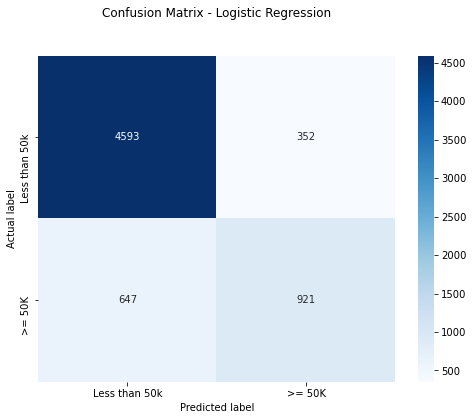

In [67]:
lr_preds = lr_scores.get('estimator')[1].predict(X)

metrics.confusion_matrix(y, lr_preds)

confusion_matrix_lr_df = pd.DataFrame(metrics.confusion_matrix(y, lr_preds))
confusion_matrix_lr_df.rename(columns = {0:'Less than 50k', 1: '>= 50K'}, inplace = True)
confusion_matrix_lr_df.rename(index = {0:'Less than 50k', 1: '>= 50K'}, inplace = True)

plt.figure(figsize=(8, 6))

# create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix_lr_df), annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix - Logistic Regression', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

## Exploring False Predictions

In [68]:
# false positives for rf
# model predicted over 50k when they really make less
index_list = X[(rf_preds == 1) & (y != rf_preds)].index
false_pos_rf = df2.iloc[index_list, :]
false_pos_rf

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,wage
24,32,self-emp-inc,195447,Bachelors,13,married-civ-spouse,Sales,husband,male,0,0,45,united-states,0
298,48,private,355978,Masters,14,married-civ-spouse,Exec-managerial,husband,male,0,0,40,united-states,0
335,43,self-emp-inc,150533,Assoc-acdm,12,married-civ-spouse,Exec-managerial,husband,male,0,0,50,united-states,0
403,38,private,107630,Bachelors,13,married-civ-spouse,Exec-managerial,husband,male,0,0,40,united-states,0
407,39,state-gov,318918,Bachelors,13,married-civ-spouse,Exec-managerial,husband,male,0,0,40,united-states,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6253,33,local-gov,248346,Assoc-acdm,12,married-civ-spouse,Craft-repair,husband,male,0,0,50,united-states,0
6271,42,private,115511,Doctorate,16,married-civ-spouse,Prof-specialty,husband,male,0,0,50,united-states,0
6278,36,private,416745,Bachelors,13,married-civ-spouse,Prof-specialty,husband,male,0,0,40,united-states,0
6345,45,local-gov,86644,Bachelors,13,married-civ-spouse,Prof-specialty,wife,female,0,0,55,united-states,0


In [69]:
false_pos_rf[(false_pos_rf['sex'] == 'male') & (false_pos_rf['native-country'] == 'united-states') & (false_pos_rf['marital-status'] == 'married-civ-spouse')]['age'].describe()

count    127.000000
mean      44.102362
std       10.451577
min       29.000000
25%       36.000000
50%       44.000000
75%       50.000000
max       90.000000
Name: age, dtype: float64

In [70]:
df2[(df2['sex'] == 'male') & (df2['native-country'] == 'united-states') & (df2['marital-status'] == 'married-civ-spouse')]['age'].describe()

count    2351.000000
mean       43.854955
std        12.216305
min        20.000000
25%        34.000000
50%        43.000000
75%        52.000000
max        90.000000
Name: age, dtype: float64

In [71]:
df2['sex'].value_counts(normalize=True)

male      0.66421
female    0.33579
Name: sex, dtype: float64

In [72]:
df2.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,wage
count,6513.000000,6.513000e+03,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000
mean,38.529556,1.926640e+05,10.068478,1059.200829,92.108092,40.400891,0.240749
std,13.684351,1.060173e+05,2.589238,7392.040587,413.710886,12.354685,0.427571
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,27.000000,1.202380e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.815760e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.417530e+05,13.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.366120e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


In [73]:
# false negatives for rf
index_list = X[(rf_preds == 0) & (y != rf_preds)].index
false_neg_rf = df2.iloc[index_list, :]
false_neg_rf

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,wage
10,64,self-emp-not-inc,103643,HS-grad,9,married-civ-spouse,Sales,husband,male,0,0,15,united-states,1
13,42,state-gov,83411,HS-grad,9,married-civ-spouse,Exec-managerial,husband,male,0,0,40,united-states,1
33,49,private,38563,Bachelors,13,never-married,Exec-managerial,not-in-family,female,0,0,56,united-states,1
49,46,private,42251,Some-college,10,married-civ-spouse,Sales,husband,male,0,0,45,united-states,1
62,40,private,326232,Some-college,10,divorced,Transport-moving,unmarried,male,0,0,40,united-states,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6479,37,private,100508,HS-grad,9,married-civ-spouse,Craft-repair,husband,male,0,0,40,united-states,1
6488,52,self-emp-inc,415037,Some-college,10,divorced,Exec-managerial,not-in-family,male,0,0,65,united-states,1
6492,60,private,139391,Some-college,10,married-spouse-absent,Machine-op-inspct,not-in-family,male,0,0,50,united-states,1
6495,27,self-emp-not-inc,153805,Some-college,10,married-civ-spouse,Transport-moving,other-relative,male,0,0,50,ecuador,1


In [74]:
# false positives for lr
index_list = X[(lr_preds == 1) & (y != lr_preds)].index
false_pos_lr = df2.iloc[index_list, :]
false_pos_lr

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,wage
21,53,private,274528,Bachelors,13,divorced,Exec-managerial,not-in-family,male,0,0,70,united-states,0
24,32,self-emp-inc,195447,Bachelors,13,married-civ-spouse,Sales,husband,male,0,0,45,united-states,0
57,52,federal-gov,207841,Some-college,10,married-civ-spouse,Adm-clerical,husband,male,0,0,40,united-states,0
100,44,private,193459,Assoc-voc,11,married-civ-spouse,Craft-repair,husband,male,3411,0,40,united-states,0
111,22,private,200109,HS-grad,9,married-civ-spouse,Priv-house-serv,wife,female,4508,0,40,united-states,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6449,52,private,203392,Some-college,10,married-civ-spouse,Craft-repair,husband,male,5013,0,40,united-states,0
6460,32,private,209103,Some-college,10,married-civ-spouse,Exec-managerial,husband,male,3464,0,40,united-states,0
6467,57,self-emp-not-inc,110417,Some-college,10,married-civ-spouse,Farming-fishing,husband,male,0,0,75,united-states,0
6468,41,federal-gov,130760,Bachelors,13,married-civ-spouse,Tech-support,husband,male,0,0,24,united-states,0


In [75]:
# false negatives for lr
index_list = X[(lr_preds == 0) & (y != lr_preds)].index
false_neg_lr = df2.iloc[index_list, :]


## Imputing to Improve

In [76]:

# getting copy of df to create numerical instead of categorical columns to use for imputation
cat_df = pd.read_csv('./data/cheap_train_sample.csv')
cat_df.replace(to_replace=' ?', value=np.nan, inplace=True)

cat_col = ['education', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country', 'workclass']

for col in cat_col:
    cat_df[col] = cat_df[col].astype('category').cat.codes
    cat_df[col] = cat_df[col].replace(to_replace= -1, value=np.nan)
    
cat_df['wage'] = cat_df['wage'].map(lambda x: 1 if x == " >50K" else 0)


In [77]:
cat_df.isnull().sum()

age                 0
workclass         363
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        365
relationship        0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    120
wage                0
dtype: int64

In [78]:
imputer = SimpleImputer(missing_values=np.nan,
                            strategy='mean')
imputer.fit(cat_df)
cat_df = pd.DataFrame(imputer.transform(cat_df), columns=cat_df.columns)

In [79]:
cat_df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
wage              0
dtype: int64

In [80]:
# setting up X and y with imputed data

X2 = cat_df.drop(columns=['wage'])
y = cat_df['wage']


# creating variables for cross_validate scores
rf_scores2 = cross_validate(rf, X2, y, cv = KFold(n_splits=5, 
                                                      shuffle=True, 
                                                      random_state=73),
                                                      n_jobs=-1,
                                                      return_train_score=True, 
                                                      return_estimator=True)

knn_scores2 = cross_validate(knn_pipe, X2, y, cv = KFold(n_splits=5, 
                                                      shuffle=True, 
                                                      random_state=73), 
                                                      n_jobs=-1,
                                                      return_train_score=True, 
                                                      return_estimator=True)

lr_scores2 = cross_validate(lr_pipe, X2, y, cv = KFold(n_splits=5, 
                                                      shuffle=True, 
                                                      random_state=73),
                                                      n_jobs=-1,
                                                      return_train_score=True, 
                                                      return_estimator=True)

# saving scores into separate dataframes
rf_results2 = pd.DataFrame(rf_scores2)
knn_results2 = pd.DataFrame(knn_scores2)
lr_results2 = pd.DataFrame(lr_scores2)

In [81]:
print(round(rf_results2['test_score'].mean(), 3), round(rf_results2['train_score'].mean(), 3))

print(f'{round(rf_results2.test_score.mean(), 3)} ± {round(2 * rf_results2.test_score.std(), 3)}')

0.846 0.991
0.846 ± 0.026


In [82]:
print(round(knn_results2['test_score'].mean(), 3), round(knn_results2['train_score'].mean(), 3))

print(f'{round(knn_results2.test_score.mean(), 3)} ± {round(2 * knn_results2.test_score.std(), 3)}')

0.816 0.871
0.816 ± 0.03


In [83]:
print(round(lr_results2['test_score'].mean(), 3), round(lr_results2['train_score'].mean(), 3))

print(f'{round(lr_results2.test_score.mean(), 3)} ± {round(2 * lr_results2.test_score.std(), 3)}')

0.827 0.828
0.827 ± 0.016


## Submission

In [87]:
# setting up X and y
X_submission = test.drop(columns=['education', 'occupation'])

# Instantiate and Fit
classifier = rf.fit(X, y)

# Submit
submit_wage = classifier.predict_proba(X_submission)

submit_df = pd.DataFrame(submit_wage, columns=['not_important', 'wage'])
submit_df.drop('not_important', axis=1, inplace=True)

submit_df.to_csv('./data/wages.csv', index=False)

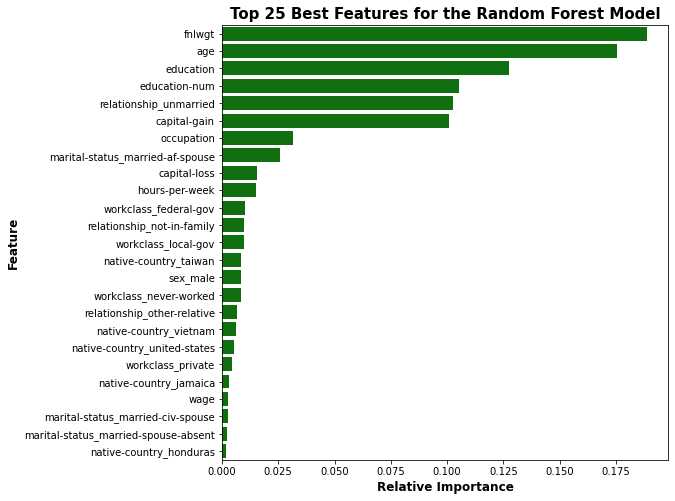

In [40]:
# FOR TESTING PURPOSES ONLY
rf = RandomForestClassifier()
rf.fit(X, y)

# get features and importances
features = list(df.columns)
importances = list(rf.feature_importances_)

# zip features and importances
best_features = list(zip(importances, features))

# create dataframe and sort for top 25 important features
top_25_features = pd.DataFrame(sorted(best_features, reverse = True))[:25]

# cleaning
new_cols = {1: 'feature', 0: 'relative_importance'}
top_25_features.rename(columns = new_cols, inplace=True)

# graph top features
fig, ax = plt.subplots(figsize = (8,8))
sns.barplot(y = 'feature', x = 'relative_importance', data = top_25_features, color = 'green')
ax.set_xlabel('Relative Importance', fontsize = 12, fontweight = 'bold')
ax.set_ylabel('Feature', fontsize = 12, fontweight = 'bold')
ax.set_title('Top 25 Best Features for the Random Forest Model', fontsize = 15, fontweight = 'bold');